In [64]:
import pandas as pd
import numpy as np

import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [65]:
# Load the dataset
data = pd.read_csv('Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [66]:
#preprocess the data
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# encode categorical variables
label_encoder_gender = LabelEncoder()
data['Gender']=label_encoder_gender.fit_transform(data['Gender'])
data

In [ ]:
#onehot encode geo column
one_hot_encoder_geo= OneHotEncoder()
geo_encoded = one_hot_encoder_geo.fit_transform(data[['Geography']])
geo_encoded = pd.DataFrame(geo_encoded.toarray(), columns=one_hot_encoder_geo.get_feature_names_out(['Geography']))
data = pd.concat([data.drop(columns=['Geography']), geo_encoded], axis=1)
data.head()






In [ ]:
# save the encoders for later use
with open('label_encoder_gender.pkl', 'wb') as f:
    pickle.dump(label_encoder_gender, f)
# save the one-hot encoder for the Geography column
with open('one_hot_encoder_geo.pkl', 'wb') as f:
    pickle.dump(one_hot_encoder_geo, f)

In [ ]:
# divide the data into features and target variable
X = data.drop(columns=['Exited'])
y = data['Exited']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # this fits and transforms the training data both features and target
X_test = scaler.transform(X_test) # this only transforms the features as the target is not part of the test data

In [ ]:
# save the scaler for later use
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

ANN Architecture - 
![alt text](image.png)

ANN TF Params

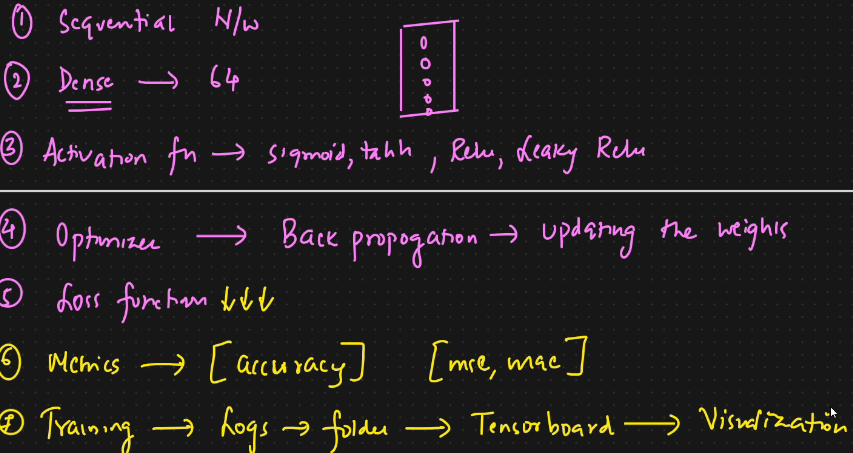


In [ ]:
import tensorflow 
import keras

In [ ]:

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import  EarlyStopping, TensorBoard
import datetime
X_train.shape[1]

The ReLU (Rectified Linear Unit) activation function is a simple yet powerful function used in artificial neural networks to introduce non-linearity and accelerate training. It outputs the input directly if it's positive, and zero if it's negative. This function is defined as f(x) = max(0, x). 

In [ ]:
# build our ANN model
# X_train.shape[1] = 12
# Dens is the layer type, 64 is the number of neurons in the layer, activation is the activation function used in the layer
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)), ## first hidden layer which has 64 neurons connected with input layer which has 12 inputs
    Dense(32, activation='relu'), ## second hidden layer connected with first hidden layer, no need to show input shape again as model already knows about first hidden layer
    Dense(1, activation='sigmoid'), ## outpute layer
])
model.summary()

Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data
Binary cross entropy (also known as logarithmic loss or log loss) is a model metric that tracks incorrect labeling of the data class by a model, penalizing the model if deviations in probability occur into classifying the labels. Low log loss values equate to high accuracy values.


In [ ]:
# tensorflow optimiser
# Adam is a popular optimiser for deep learning models
# binary_crossentropy is used for binary classification problems
opt = keras.optimizers.Adam(learning_rate=0.01)
loss = keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])


In [ ]:
# setup the tensoorboard with the tensorboard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
# early stopping callback
# val_loss is validation loss, patience is the number of epochs with no improvement after which training will be stopped 
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 


When we mention validation_split as fit parameter while fitting DL model, it splits data into two parts for every epoch i.e. training data and validation data. It trains the model on training data and validate the model on validation data by checking its loss and accuracy.

Usually with every epoch increasing, loss goes lower and accuracy goes higher. But with val_loss and val_acc, many cases can be possible:

val_loss starts increasing, val_acc starts decreasing(means model is cramming values not learning)

val_loss starts increasing, val_acc also increases.(could be case of overfitting or diverse probability values in cases softmax is used in output layer)

val_loss starts decreasing, val_acc starts increasing(Correct, means model build is learning and working fine)

In [ ]:
# train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, 
                    callbacks=[tensorboard_callback, early_stopping], 
                    verbose=1) # verbose=1 will show the progress bar and loss at each epoch

In [ ]:
# save the model in keras expected h5 file
model.save('model.keras') # save the model for later use


In [ ]:
# load tensorboard
%load_ext tensorboard
%tensorboard --logdir logs/fit 



In [ ]:
# load the piccked model and scalers
